In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/LULU.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,77.730003,77.959999,73.349998,74.019997,74.019997,3113800
1,1/3/2013,73.589996,76.050003,73.360001,75.089996,75.089996,1801800
2,1/4/2013,72.349998,72.550003,70.269997,71.949997,71.949997,6142700
3,1/7/2013,71.190002,72.019997,70.099998,71.099998,71.099998,2564400
4,1/8/2013,71.269997,71.669998,70.360001,71.629997,71.629997,2226100


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 1194.189975.3, cost: 0.073021, total money: 10098.809955
epoch: 20, total rewards: 297.169921.3, cost: 0.075652, total money: 10297.169921
epoch: 30, total rewards: 132.369922.3, cost: 0.053246, total money: 10132.369922
epoch: 40, total rewards: 141.559947.3, cost: 0.046887, total money: 10141.559947
epoch: 50, total rewards: 175.519927.3, cost: 0.047948, total money: 10175.519928
epoch: 60, total rewards: 57.989925.3, cost: 0.044251, total money: 10057.989925
epoch: 70, total rewards: 64.809910.3, cost: 0.047279, total money: 10064.809910
epoch: 80, total rewards: 95.259960.3, cost: 0.040583, total money: 10095.259960
epoch: 90, total rewards: 81.709988.3, cost: 0.036709, total money: 10081.709988
epoch: 100, total rewards: 82.959984.3, cost: 0.034856, total money: 10082.959984
epoch:

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 5: buy 1 unit at price 71.040001, total balance 9928.959999
day 6, sell 1 unit at price 70.580002, investment -0.647521 %, total balance 9999.540001,
day 10: buy 1 unit at price 67.440002, total balance 9932.099998
day 11, sell 1 unit at price 68.150002, investment 1.052786 %, total balance 10000.250000,
day 20: buy 1 unit at price 69.000000, total balance 9931.250000
day 21: buy 1 unit at price 67.860001, total balance 9863.389999
day 24, sell 1 unit at price 68.080002, investment -1.333331 %, total balance 9931.470001,
day 25: buy 1 unit at price 67.629997, total balance 9863.840004
day 26, sell 1 unit at price 68.040001, investment 0.265252 %, total balance 9931.880005,
day 27, sell 1 unit at price 67.349998, investment -0.414016 %, total balance 9999.230003,
day 39: buy 1 unit at price 67.050003, total balance 9932.180000
day 40, sell 1 unit at price 67.500000, investment 0.671136 %, total balance 9999.680000,
day 55: buy 1 unit at price 62.349998, total balance 9937.330002
day

day 364, sell 1 unit at price 37.610001, investment 0.966445 %, total balance 9973.740028,
day 366: buy 1 unit at price 38.709999, total balance 9935.030029
day 367, sell 1 unit at price 39.880001, investment 3.022480 %, total balance 9974.910030,
day 373: buy 1 unit at price 40.490002, total balance 9934.420029
day 374: buy 1 unit at price 40.419998, total balance 9894.000031
day 376, sell 1 unit at price 40.270000, investment -0.543347 %, total balance 9934.270031,
day 377, sell 1 unit at price 41.400002, investment 2.424551 %, total balance 9975.670033,
day 384: buy 1 unit at price 38.869999, total balance 9936.800034
day 385, sell 1 unit at price 38.660000, investment -0.540260 %, total balance 9975.460033,
day 387: buy 1 unit at price 37.980000, total balance 9937.480034
day 388, sell 1 unit at price 38.150002, investment 0.447609 %, total balance 9975.630035,
day 389: buy 1 unit at price 37.509998, total balance 9938.120037
day 390, sell 1 unit at price 37.529999, investment 0.05

day 858, sell 1 unit at price 65.029999, investment 4.988699 %, total balance 9948.220047,
day 871: buy 1 unit at price 71.709999, total balance 9876.510048
day 872, sell 1 unit at price 71.779999, investment 0.097615 %, total balance 9948.290047,
day 874: buy 1 unit at price 71.360001, total balance 9876.930046
day 876: buy 1 unit at price 69.620003, total balance 9807.310043
day 877, sell 1 unit at price 69.000000, investment -3.307176 %, total balance 9876.310043,
day 881, sell 1 unit at price 73.959999, investment 6.233835 %, total balance 9950.270042,
day 887: buy 1 unit at price 76.620003, total balance 9873.650040
day 889, sell 1 unit at price 77.419998, investment 1.044108 %, total balance 9951.070038,
day 897: buy 1 unit at price 77.180000, total balance 9873.890038
day 898, sell 1 unit at price 76.820000, investment -0.466443 %, total balance 9950.710037,
day 905: buy 1 unit at price 77.800003, total balance 9872.910034
day 907, sell 1 unit at price 77.739998, investment -0.0

day 1343: buy 1 unit at price 99.860001, total balance 9865.560032
day 1344: buy 1 unit at price 95.489998, total balance 9770.070034
day 1347, sell 1 unit at price 98.959999, investment -0.901263 %, total balance 9869.030033,
day 1348, sell 1 unit at price 97.910004, investment 2.534303 %, total balance 9966.940037,
day 1358: buy 1 unit at price 106.410004, total balance 9860.530033
day 1359, sell 1 unit at price 106.180000, investment -0.216148 %, total balance 9966.710033,
day 1372: buy 1 unit at price 125.879997, total balance 9840.830036
day 1375, sell 1 unit at price 128.100006, investment 1.763591 %, total balance 9968.930042,
day 1377: buy 1 unit at price 127.709999, total balance 9841.220043
day 1378, sell 1 unit at price 124.180000, investment -2.764074 %, total balance 9965.400043,
day 1380: buy 1 unit at price 126.790001, total balance 9838.610043
day 1381, sell 1 unit at price 123.879997, investment -2.295137 %, total balance 9962.490040,
day 1386: buy 1 unit at price 124.

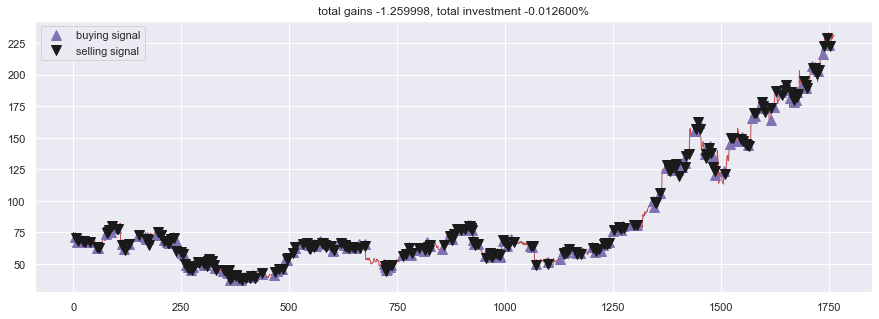

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()